# Inspekcja danych

W poniższym notebooku zawarto analizę nowych danych, ich wpływ na jakość modelu. Notebook ma charakter roboczy, pozwolił wyciągnąć wnioski, że budowa sensownie działającego modelu w oparciu o nowe dane jest trudna/niemożliwa. Badano również zjawisko wycieku. danych. 

# Initialization

In [ ]:
!pip install Unidecode
!pip install --upgrade pandas

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.2)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
prefix = "/content/drive/My Drive/ColabLamoda/"
#!ls "/content/drive/My Drive/ColabLamoda"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import re
import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor

pd.set_option('display.max_rows', 500)
train_test_split = 0.6

## Model (fit and predict)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, roc_curve, auc, roc_auc_score

In [ ]:
xgb = XGBClassifier(n_estimators=100)

In [ ]:
def show_score(y, y_pred):
    fpr, tpr, threshold = roc_curve(y.astype('int'), y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, "blue", label = f'AUC = {roc_auc}')

    plt.title('Receiver Operating Characteristic')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
def fit_selected_columns(X, y, columns, train_test_split=0.6):
    split = int(train_test_split * len(X))
    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    
    xgb.fit(X_train[columns], y_train)
    
    print("TRAIN:")
    y_train_pred = xgb.predict_proba(X_train[columns])[:,1]
    show_score(y_train, y_train_pred)
    
    print("TEST:")
    y_test_pred = xgb.predict_proba(X_test[columns])[:,1]
    show_score(y_test, y_test_pred)
    
    return y# device == null => data leak => remove rows

## Ceteris paribus

In [ ]:
def plot_feature(model, x_source, feature_number, feature_range, feature_categories=None):
    X = pd.DataFrame([x_source for t in feature_range] + [x_source])
    X.iloc[:len(feature_range), feature_number] = list(feature_range)
    
    y_pred = model.predict_proba(X)
    y_pred = [x[1] for x in y_pred]
    
    plt.plot(X.iloc[:-1,feature_number], y_pred[:-1])
    if feature_categories is not None:
        plt.xticks(X.iloc[:-1,feature_number], [feature_categories[int(t)] for t in X.iloc[:-1,feature_number]], rotation='vertical')
    
    plt.scatter(x_source[feature_number], y_pred[-1], s=40, c='black')
    plt.xlabel(X.columns[feature_number])

# Data preparation

## Load data

In [ ]:
base = pd.read_csv(f"{prefix}base.csv", index_col=0)
#product = pd.read_csv(f"{prefix}product.csv", index_col=0)
#transaction = pd.read_csv(f"{prefix}transaction.csv", index_col=0)

X_trans_train = pd.read_pickle(f"{prefix}X_train_transaction.pkl")
y = pd.read_csv(f"{prefix}y_train.csv", header=None, index_col=0) > 0

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Basic transformations

### Quick look

In [ ]:
base.isna().sum() / len(base)

offerID                   0.000000
categoryID                0.000000
productID                 0.000000
productBrand              0.000000
productBrandMapped        0.001636
state                     0.001636
price                     0.001636
priceBase                 0.001636
discountPercent           0.001636
statusScore               0.001636
userID                    0.001636
scorePopularity           0.001636
scorePopularityGPTestC    0.001636
categoryName              0.000000
dtype: float64

In [ ]:
X_trans_train.isna().sum() / len(X_trans_train)

productSKU             0.000000
productListName        0.000000
productListPosition    0.000000
date                   0.000001
cookieID               0.000000
marketingChannel       0.000000
views                  0.000000
city                   0.146763
landingPage            0.146763
device                 0.146763
dtype: float64

### Transformations

In [ ]:
base['offerID'] = pd.to_numeric(base['offerID'], errors='coerce')

In [ ]:
X_trans_train["productSKU"] = pd.to_numeric(X_trans_train["productSKU"], errors='coerce')

In [ ]:
X_trans_train['productListPosition'] = pd.to_numeric(X_trans_train['productListPosition'], errors='coerce')

In [ ]:
y = y.astype("int").values.reshape(-1,)

## Merge

In [ ]:
X = X_trans_train.merge(base, left_on="productSKU", right_on="offerID", how="left", indicator=True)

In [ ]:
X.dtypes

productSKU                 float64
productListName             object
productListPosition        float64
date                       float64
cookieID                    object
marketingChannel            object
views                        int64
city                        object
landingPage                 object
device                      object
offerID                    float64
categoryID                 float64
productID                  float64
productBrand                object
productBrandMapped          object
state                       object
price                      float64
priceBase                  float64
discountPercent            float64
statusScore                float64
userID                     float64
scorePopularity            float64
scorePopularityGPTestC     float64
categoryName                object
_merge                    category
dtype: object

## Feature extraction

In [ ]:
split = int(train_test_split * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

X_temp = X_test.copy()
X_temp["y"] = y_test

### Baseline

TRAIN:


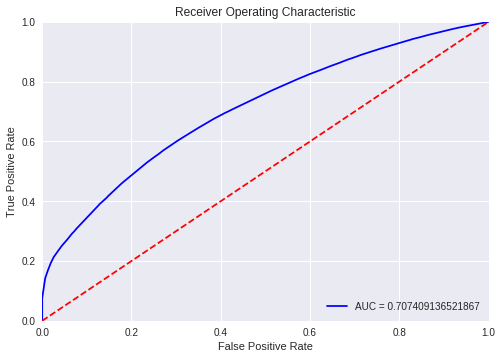

TEST:


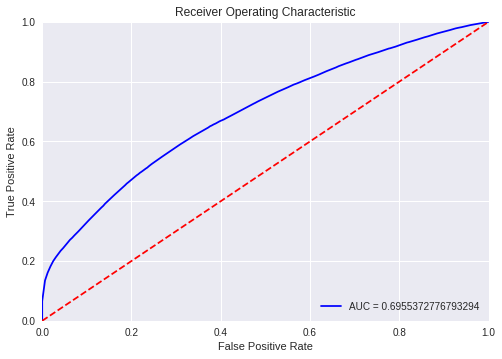

In [ ]:
fit_selected_columns(X, y, ["productListPosition"])

### Cities

In [ ]:
cities = pd.read_html("https://pl.wikipedia.org/wiki/Dane_statystyczne_o_miastach_w_Polsce")[0]
cities.columns = ['city','powiat', 'voivodeship', 'area', 'population', 'density']

cities['population'] = cities['population'].apply(lambda x: int("".join(re.findall(r'\d+', x))))
#Usuniecie polskich znakow
cities['city'] = cities['city'].apply(lambda x: unidecode.unidecode(x))
cities.loc[cities['city']=="Warszawa", "city"] = "Warsaw"
#if duplicates choose bigger city
cities = cities.sort_values("population")
cities = cities[~cities['city'].duplicated(keep="last")]

In [ ]:
X = X.merge(cities, how="left", left_on="city", right_on="city")

TRAIN:


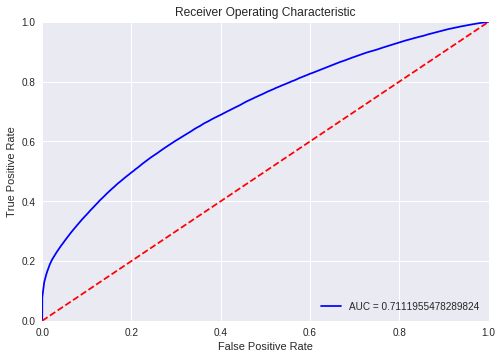

TEST:


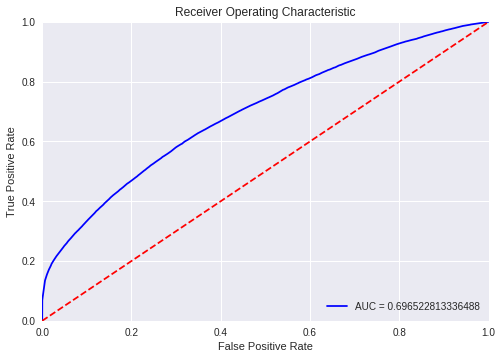

In [ ]:
fit_selected_columns(X, y, ["productListPosition", "population"])

### Product brand

In [ ]:
column = "productBrand"
selected_brands = X_temp[[column, "y"]].groupby(by=column, as_index=False).count()
selected_brands = selected_brands[selected_brands["y"]>10000]
selected_brands.head(5)
len(selected_brands)

11

In [ ]:
X["brand"] = [brand if brand in selected_brands["productBrand"].values else np.nan for brand in X["productBrand"]]

In [ ]:
X["brand_code"] = X["brand"].astype('category').cat.codes.astype('int')

TRAIN:


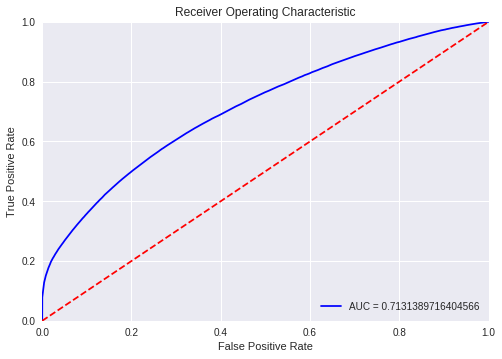

TEST:


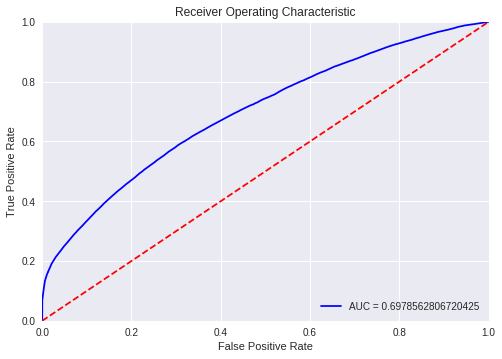

In [ ]:
fit_selected_columns(X, y, ["productListPosition", "population", "brand_code"])

### Marketing channel

In [ ]:
sum(X["marketingChannel"].isna()) / len(X["marketingChannel"])

0.0

In [ ]:
X_temp.groupby("marketingChannel")\
    .agg({'y':'sum', "marketingChannel":'size'})\
    .rename(columns={"y": "clicks", "marketingChannel": "views"})

,clicks,views
marketingChannel,,
(Other),2191,133512
(other),3,8
Affiliates,0,1
Direct,8223,89354
Display,159,19383
Email,5773,896894
Organic Search,6978,780233
Paid Search,9882,1260683
Push,321,41346


In [ ]:
X["marketingChannel"] = X["marketingChannel"].replace("(other)", "-1")
X["marketingChannel"] = X["marketingChannel"].replace("(Other)", "-1")
X["marketingChannel"] = X["marketingChannel"].replace("Affiliates", "-1")
X["marketingChannel"] = X["marketingChannel"].replace("content cpc", "-1")

In [ ]:
split = int(train_test_split * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

X_temp = X_test.copy()
X_temp["y"] = y_test

In [ ]:
column = "marketingChannel"
marketingChannels = X_temp[[column, "y"]].groupby(by=column, as_index=False).count()
marketingChannels

,marketingChannel,y
0,-1,134449
1,Direct,89354
2,Display,19383
3,Email,896894
4,Organic Search,780233
5,Paid Search,1260683
6,Push,41346
7,Referral,41669
8,Retargeting,271334
9,Social,64655


In [ ]:
len(marketingChannels)

10

In [ ]:
X[f"{column}_code"] = X[column].astype('category').cat.codes.astype('int')

TRAIN:


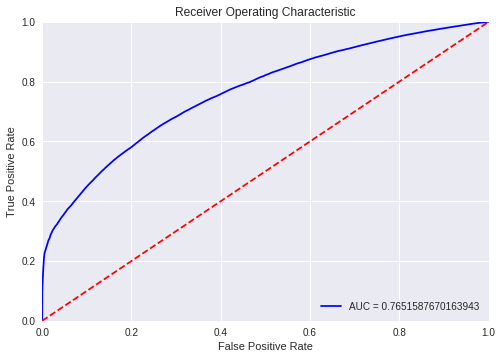

TEST:


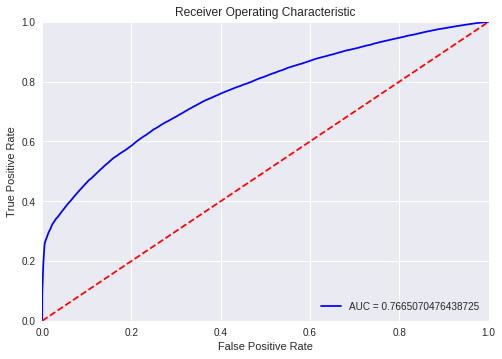

In [ ]:
fit_selected_columns(X, y, ["productListPosition", "population", "brand_code", "marketingChannel_code"])

### Device

In [ ]:
column = "device"
devices = X_temp[[column, "y"]].groupby(by=column, as_index=False).count()
devices

,device,y
0,desktop,922026
1,mobile,379434
2,none,1730860
3,tablet,63163


In [ ]:
X[f"{column}_code"] = X[column].astype('category').cat.codes.astype('int')

TRAIN:


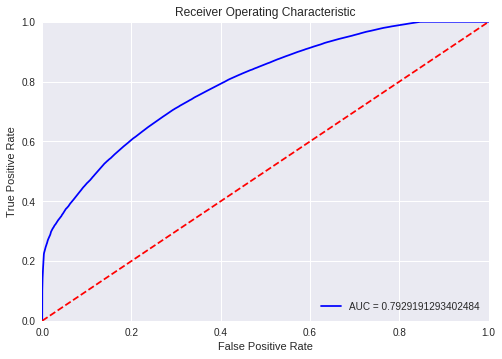

TEST:


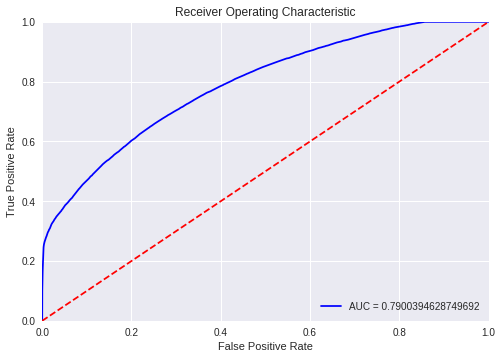

In [ ]:
fit_selected_columns(X, y, ["productListPosition", "population", "brand_code", "marketingChannel_code", "device_code"])

### ProductListPosition normalization

In [ ]:
threshold = 2000

In [ ]:
X["productListPosition_normalized"] = [np.log(x) if x<threshold else np.log(threshold) for x in X["productListPosition"]+1]

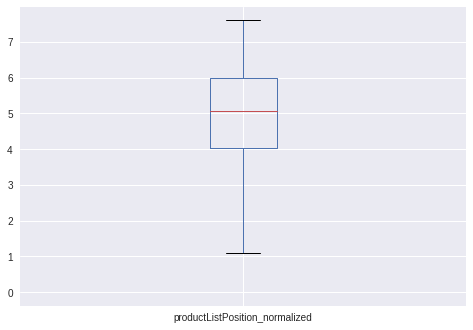

In [ ]:
X.boxplot(column="productListPosition_normalized")

TRAIN:


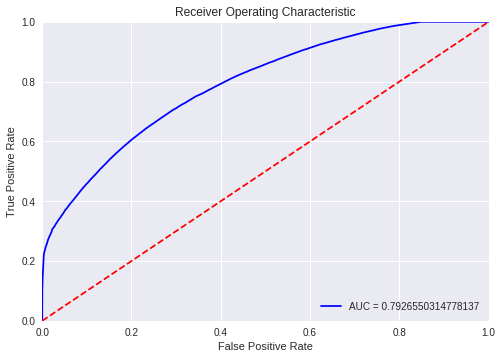

TEST:


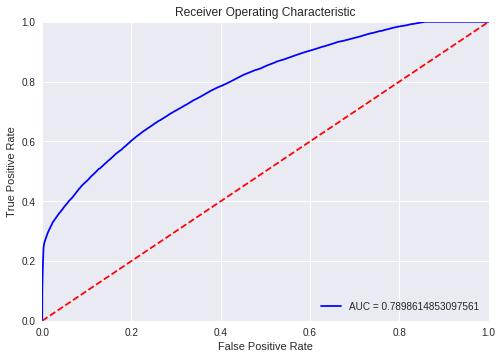

In [ ]:
fit_selected_columns(X, y, ["productListPosition", "population", "brand_code", "marketingChannel_code", "device_code", "productListPosition_normalized"])

### Price

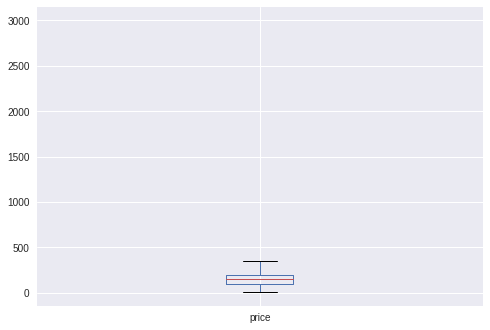

In [ ]:
X.boxplot(column="price")

TRAIN:


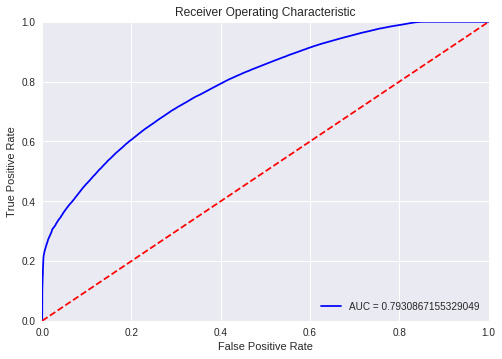

TEST:


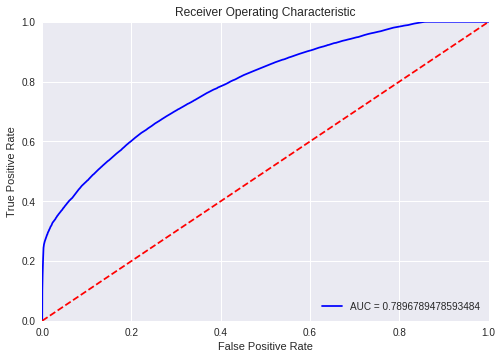

In [ ]:
fit_selected_columns(X, y, ["productListPosition", "population", "brand_code", "marketingChannel_code",
                            "device_code", "productListPosition_normalized", "price"])

### Discount percent

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78b7690fd0>]],
      dtype=object)

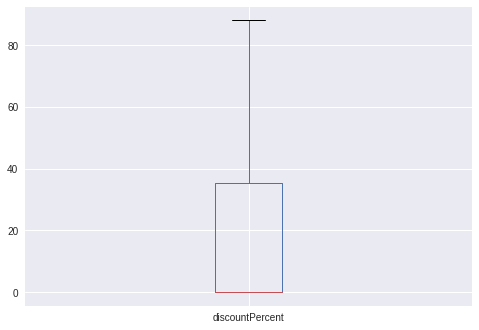

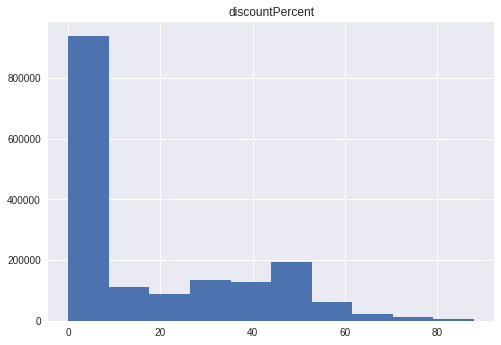

In [ ]:
X.boxplot(column=["discountPercent"])
X.hist(column=["discountPercent"])

TRAIN:


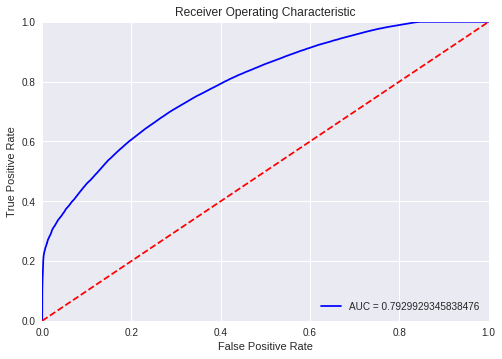

TEST:


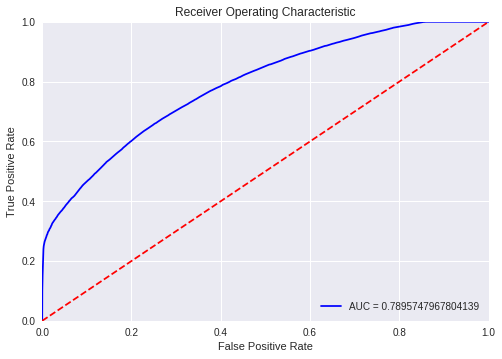

In [ ]:
fit_selected_columns(X, y, ["productListPosition", "population", "brand_code", "marketingChannel_code",
                            "device_code", "productListPosition_normalized", "price", "discountPercent"])

### Score popularity

In [ ]:
X["scorePopularity"] = X["scorePopularity"].fillna(0)
scorePopularity_transition = np.sort(X["scorePopularity"].astype('int').unique())
scorePopularity_transition = dict(zip(scorePopularity_transition, range(len(scorePopularity_transition))))
scorePopularity_transition

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 13: 12,
 14: 13,
 20: 14,
 37: 15,
 1000: 16,
 1001: 17,
 1002: 18,
 1004: 19,
 1005: 20,
 1006: 21,
 2001: 22,
 2003: 23,
 2011: 24,
 3002: 25,
 3003: 26,
 3005: 27,
 3006: 28,
 3007: 29,
 4002: 30,
 4006: 31,
 5003: 32,
 5009: 33,
 5010: 34,
 7000: 35,
 8005: 36,
 20005: 37}

In [ ]:
X["scorePopularity_code"] = X["scorePopularity"].apply(lambda x: scorePopularity_transition[x])

TRAIN:


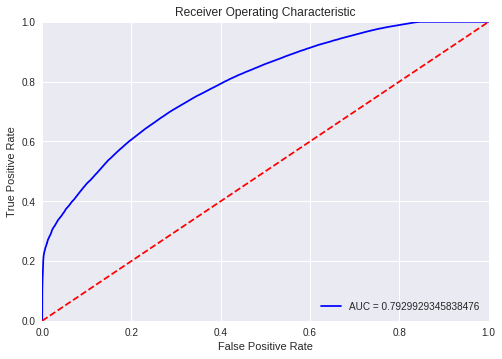

TEST:


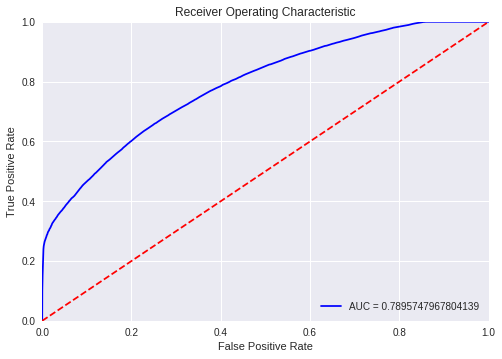

In [ ]:
fit_selected_columns(X, y, ["productListPosition", "population", "brand_code", "marketingChannel_code",
                            "device_code", "productListPosition_normalized", "price", "discountPercent",
                            "scorePopularity_code"])

### Score popularity GPTestC

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff909d3d080>]],
      dtype=object)

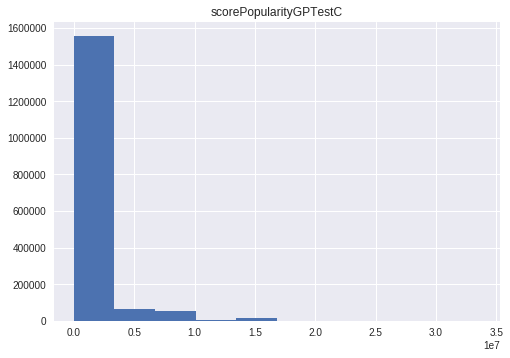

In [ ]:
X.hist(column=["scorePopularityGPTestC"])

TRAIN:


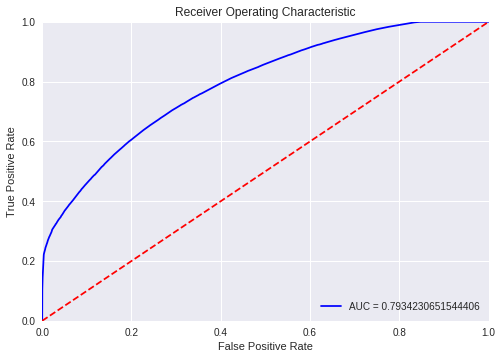

TEST:


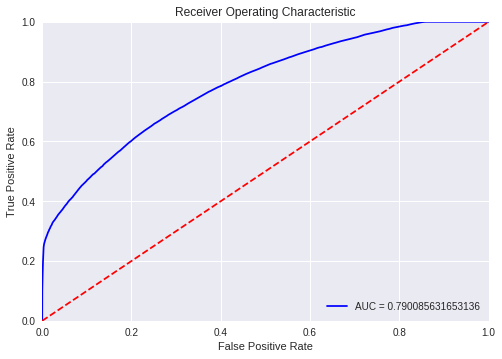

In [ ]:
fit_selected_columns(X, y, ["productListPosition", "population", "brand_code", "marketingChannel_code",
                            "device_code", "productListPosition_normalized", "price", "discountPercent",
                            "scorePopularity_code", "scorePopularityGPTestC"])

### Powiat, voivodeship, area, density

In [ ]:
print("Unique")
print(f"Powiat: {len(X['powiat'].unique())}")
print(f"Voivodeship: {len(X['voivodeship'].unique())}")
print(f"Area: {len(X['area'].unique())}")

Unique
Powiat: 353
Voivodeship: 17
Area: 561


In [ ]:
X["voivodeship_code"] = X["voivodeship"].astype('category').cat.codes.astype('int')

TRAIN:


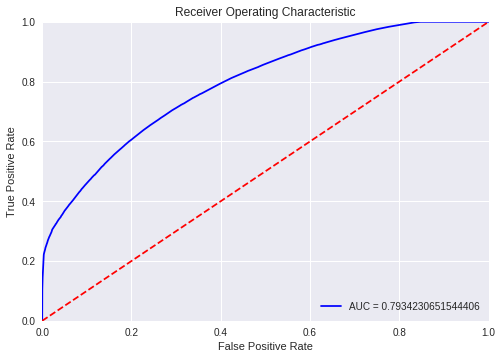

TEST:


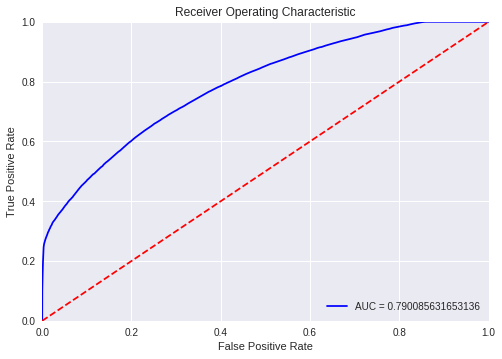

In [ ]:
fit_selected_columns(X, y, ["productListPosition", "population", "brand_code", "marketingChannel_code",
                            "device_code", "productListPosition_normalized", "price", "discountPercent",
                            "scorePopularity_code", "scorePopularityGPTestC", "voivodeship_code"])

### Save files

In [ ]:
X.to_csv(f"{prefix}X_2019_04_11.csv", sep=",", index=False)
pd.DataFrame(y, columns=["y"]).to_csv(f"{prefix}y_2019_04_11.csv", sep=",", index=False)

# Segments

In [ ]:
X = pd.read_csv(f"{prefix}X_2019_04_11.csv", sep=",")
y = pd.read_csv(f"{prefix}y_2019_04_11.csv", sep=",")["y"].values

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,14,15,23,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#X["device"].unique()
X["device"] = X["device"].replace("none", np.nan)

In [ ]:
X.columns

Index(['productSKU', 'productListName', 'productListPosition', 'date',
       'cookieID', 'marketingChannel', 'views', 'city', 'landingPage',
       'device', 'offerID', 'categoryID', 'productID', 'productBrand',
       'productBrandMapped', 'state', 'price', 'priceBase', 'discountPercent',
       'statusScore', 'userID', 'scorePopularity', 'scorePopularityGPTestC',
       'categoryName', '_merge', 'powiat', 'voivodeship', 'area', 'population',
       'density', 'brand', 'brand_code', 'marketingChannel_code',
       'device_code', 'productListPosition_normalized', 'scorePopularity_code',
       'voivodeship_code'],
      dtype='object')

In [ ]:
# device == null => data leak => remove rows
y = y[X["device"].notna()].copy()
X = X[X["device"].notna()].copy()

In [ ]:
len(X)

In [ ]:
X = X[:int(len(X)/2)].copy()
y = y[:int(len(y)/2)].copy()

In [ ]:
landingPage_categories = ["buty", "ubrania", "torebki"]
for category in landingPage_categories:
    X[category] = [1 if (type(path) is str) and (category in path) else 0 for path in X["landingPage"]]

In [ ]:
Xs = X[["population", "marketingChannel", "device", "voivodeship", *landingPage_categories]].copy()

In [ ]:
y = y[X["device"].notna()].copy()

In [ ]:
Xs_dummies = pd.get_dummies(Xs)

In [ ]:
Xs_dummies.columns

Index(['population', 'buty', 'ubrania', 'torebki', 'marketingChannel_-1',
       'marketingChannel_Direct', 'marketingChannel_Display',
       'marketingChannel_Email', 'marketingChannel_Organic Search',
       'marketingChannel_Paid Search', 'marketingChannel_Push',
       'marketingChannel_Referral', 'marketingChannel_Retargeting',
       'marketingChannel_Social', 'device_desktop', 'device_mobile',
       'device_tablet', 'voivodeship_dolnośląskie',
       'voivodeship_kujawsko-pomorskie', 'voivodeship_lubelskie',
       'voivodeship_lubuskie', 'voivodeship_mazowieckie',
       'voivodeship_małopolskie', 'voivodeship_opolskie',
       'voivodeship_podkarpackie', 'voivodeship_podlaskie',
       'voivodeship_pomorskie', 'voivodeship_warmińsko-mazurskie',
       'voivodeship_wielkopolskie', 'voivodeship_zachodniopomorskie',
       'voivodeship_łódzkie', 'voivodeship_śląskie',
       'voivodeship_świętokrzyskie'],
      dtype='object')

Allowed:
1. Źródło marketingowe
2. Miasto
3. Rodzaj urządzenia
4. Landing page

TRAIN:


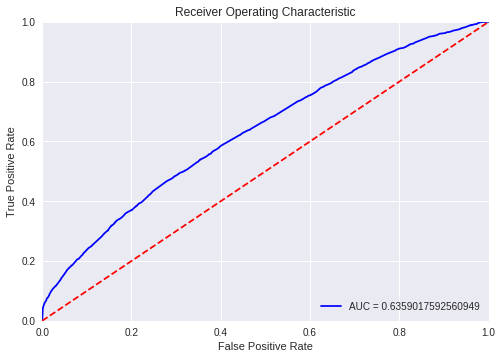

TEST:


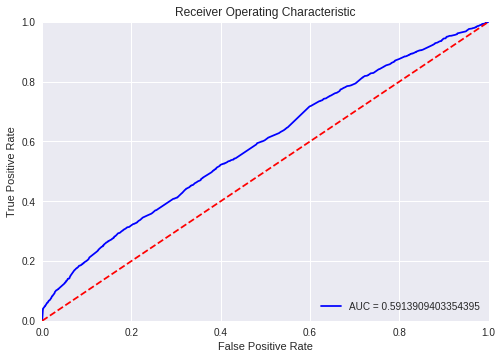

In [ ]:
fit_selected_columns(Xs_dummies, y, Xs_dummies.columns)

In [ ]:
Xs_dummies.isna().sum() / len(Xs_dummies)

population                         0.249113
buty                               0.000000
ubrania                            0.000000
torebki                            0.000000
marketingChannel_-1                0.000000
marketingChannel_Direct            0.000000
marketingChannel_Display           0.000000
marketingChannel_Email             0.000000
marketingChannel_Organic Search    0.000000
marketingChannel_Paid Search       0.000000
marketingChannel_Push              0.000000
marketingChannel_Referral          0.000000
marketingChannel_Retargeting       0.000000
marketingChannel_Social            0.000000
device_desktop                     0.000000
device_mobile                      0.000000
device_tablet                      0.000000
voivodeship_dolnośląskie           0.000000
voivodeship_kujawsko-pomorskie     0.000000
voivodeship_lubelskie              0.000000
voivodeship_lubuskie               0.000000
voivodeship_mazowieckie            0.000000
voivodeship_małopolskie         

In [ ]:
Xs_dummies["population"] = Xs_dummies["population"].fillna(Xs_dummies["population"].median())

In [ ]:
model_whitebox = DecisionTreeRegressor(max_depth = 3)
model_whitebox.fit(Xs_dummies, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [ ]:
# Visualisation based on code example:
# https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

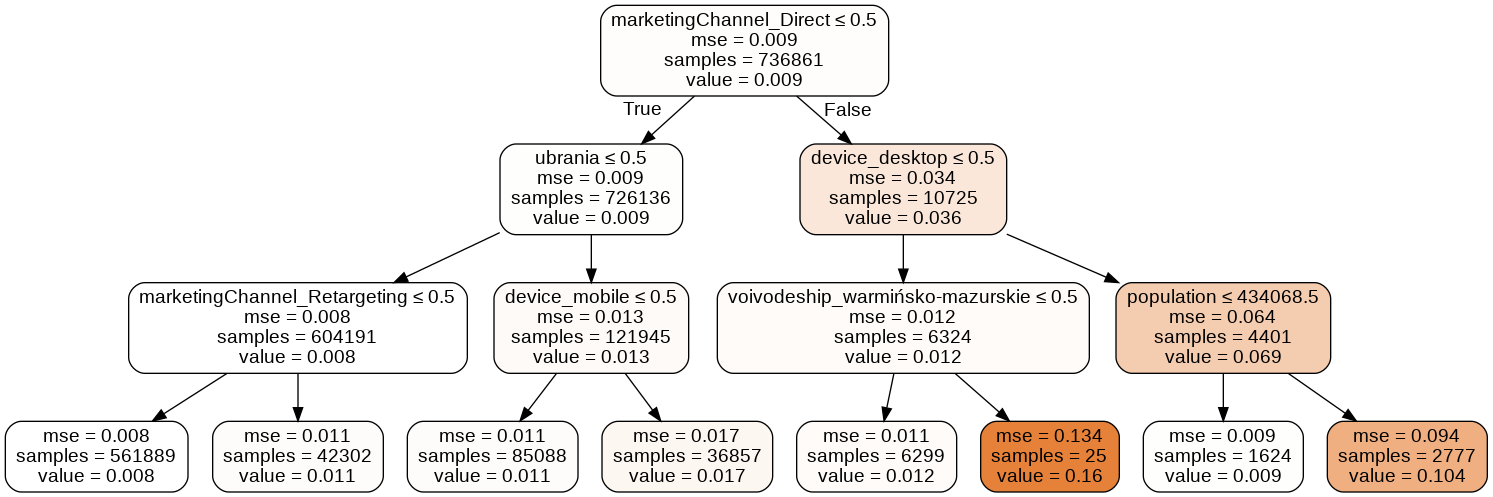

In [ ]:
export_graphviz(model_whitebox, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=Xs_dummies.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
whitebox_y_pred = model_whitebox.predict(Xs_dummies)
show_score(y, whitebox_y_pred)

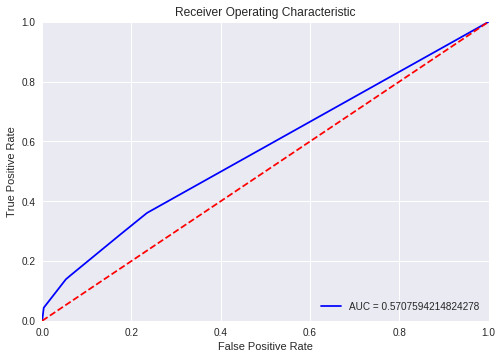

TRAIN:


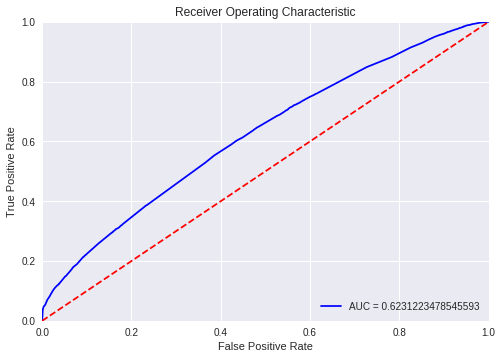

TEST:


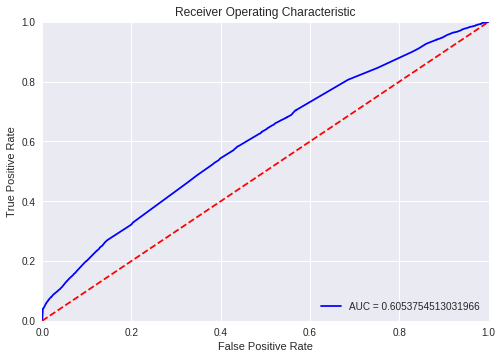

(array([0.00772385, 0.00958848, 0.00958848, ..., 0.00703656, 0.01116494,
        0.00945118], dtype=float32),
 array([0.00958848, 0.0046093 , 0.00454995, ..., 0.00696957, 0.00917793,
        0.00878018], dtype=float32))

In [ ]:
# "productListPosition" "productListPosition_normalised"
fit_selected_columns(X, y, ["population", "brand_code", "marketingChannel_code",
                            "device_code", "price", "discountPercent",
                            "scorePopularity_code", "scorePopularityGPTestC", "voivodeship_code"])

TRAIN:


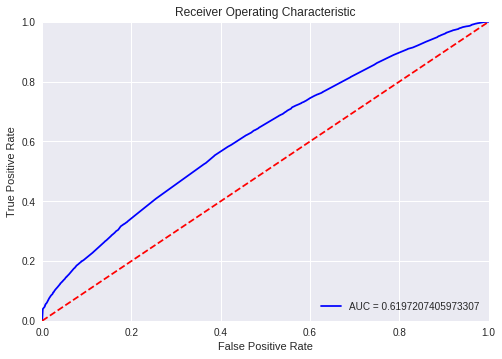

TEST:


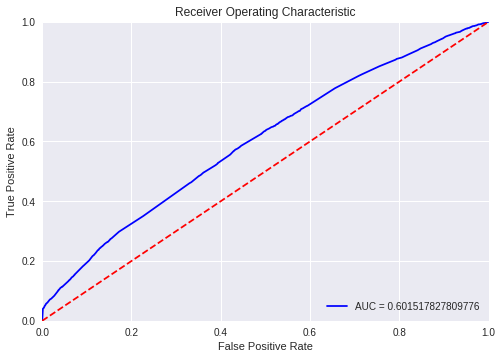

(array([0.00766737, 0.00960631, 0.00960631, ..., 0.00700635, 0.01143706,
        0.00959758], dtype=float32),
 array([0.00960631, 0.00730023, 0.0074116 , ..., 0.00690102, 0.00937914,
        0.00884911], dtype=float32))

In [ ]:
# "productListPosition" "productListPosition_normalised"
fit_selected_columns(X, y, ["population", "brand_code", "marketingChannel_code",
                            "device_code", "price", "discountPercent",
                            "voivodeship_code"])

In [ ]:
X[["population", "brand_code", "marketingChannel_code",
                            "device_code", "price", "discountPercent",
                            "voivodeship_code"]].isna().sum()

population                293742
brand_code                     0
marketingChannel_code          0
device_code                    0
price                    1259585
discountPercent          1259585
voivodeship_code               0
dtype: int64

In [ ]:
Xmedian = X[["population", "brand_code", "marketingChannel_code", "device_code", "price", "discountPercent", "voivodeship_code"]].copy()

In [ ]:
for col in Xmedian.columns:
    Xmedian[col] = Xmedian[col].fillna(Xmedian[col].median())

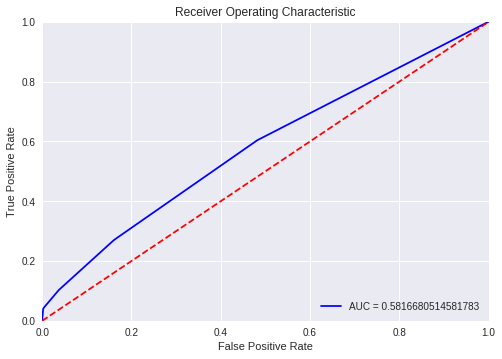

In [ ]:
model_whitebox = DecisionTreeRegressor(max_depth = 3)
model_whitebox.fit(Xmedian, y)
whitebox_y_pred = model_whitebox.predict(Xmedian)
show_score(y, whitebox_y_pred)

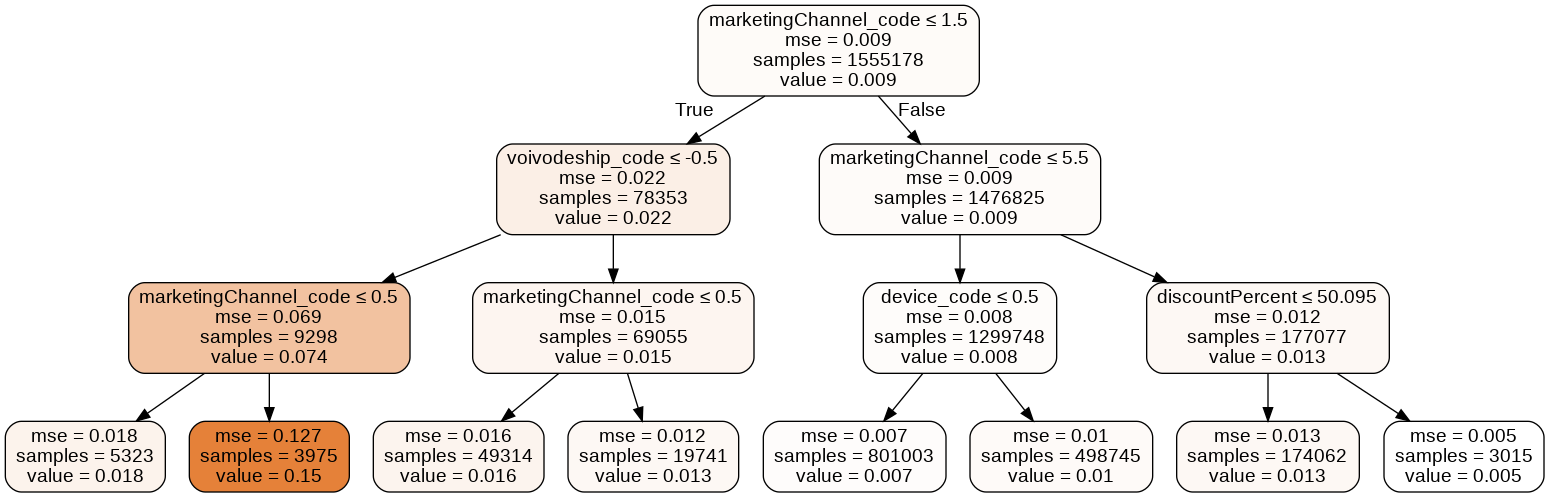

In [ ]:
export_graphviz(model_whitebox, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=Xmedian.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Gdzie w nowych danych (plik_1, plik_2, konwersje) możemy znaleźć informacje, że ktoś widział danych produkt i go nie kliknął?

Ranking obliczany jest raz dziennie dla każdego segmentu. Powiedzmy że mamy 30 segmentów i dla każdego czas wyznaczenia rankingu to 10sekund. Daje to 5min na wyznaczenie nowego rankingu na dzień co wydaje się wystarczająco szybkie. Skąd zatem ograniczenie do 15ms?

Jeśli do wyboru segmentu liczymy np 6 parametrów to żeby pokryć wszystkich użytkowników trzeba by 2^6 = 64 koszyki? Na pewno o to chodzi? 

W starym zbiorze
    
    City == none + marketingChannel == none >> leak
    
    Device == none >> leak

Ze względu na ilość wycieków trzeba je wszystkie poznajdować i wyrzucić ze zbioru (testowego i uczącego)

### TODO: Device==nan >> leak

In [ ]:
Xy.iloc[np.argsort(y_test_pred)]

,population,marketingChannel,device,voivodeship,buty,ubrania,torebki,y
1079507,1764615.0,Direct,tablet,mazowieckie,1,0,0,0
1103566,1764615.0,Direct,tablet,mazowieckie,1,0,0,0
1457115,1764615.0,Direct,tablet,mazowieckie,1,0,0,0
1896061,1764615.0,Direct,tablet,mazowieckie,1,0,0,0
1828849,1764615.0,Direct,tablet,mazowieckie,1,0,0,0
1428434,1764615.0,Direct,tablet,mazowieckie,1,0,0,0
1138599,1764615.0,Direct,tablet,mazowieckie,1,0,0,0
1079520,1764615.0,Direct,tablet,mazowieckie,1,0,0,0
1139168,1764615.0,Direct,tablet,mazowieckie,1,0,0,0
1550986,1764615.0,Direct,tablet,mazowieckie,1,0,0,0


# TODO

### todo: Product list name

In [ ]:
X["productListName"][5].replace("http://lamoda.pl/", "").replace("katalog/", "")

'tag-torebki-w-kwiaty'

### todo: Known users

In [ ]:
X["cookieID"] = X["cookieID"].replace("undefined", np.nan)

In [ ]:
X["cookieID"] = [id if "%hash%" not in id and id!="nan" else np.nan for id in X["cookieID"].astype("str")]

In [ ]:
split = int(train_test_split * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

X_temp = X_test.copy()
X_temp["y"] = y_test

In [ ]:
known_users = X_temp[["y", "cookieID"]]\
    .groupby(by="cookieID", as_index=False).count()\
    .sort_values(by="y", ascending=False)
known_users = known_users[known_users["y"]>50]
len(known_users)

15863

### todo: Mean product price by user. Under development!

In [ ]:
X = X[["price", "cookieID"]].copy()

In [ ]:
X["y"] = y_train_2.values

In [ ]:
tDf = tDf[tDf["y"]].groupby("cookieID", as_index=False)\
    .agg({'y':'size', 'price':'median'})\
    .rename(columns={"y": "clicks_number", "price": "mean_selected_product_price"})

In [ ]:
tDf = tDf[tDf["clicks_number"]>2][["cookieID", "mean_selected_product_price"]]

In [ ]:
dfXy = dfXy.merge(tDf, how="left", left_on="cookieID", right_on="cookieID")

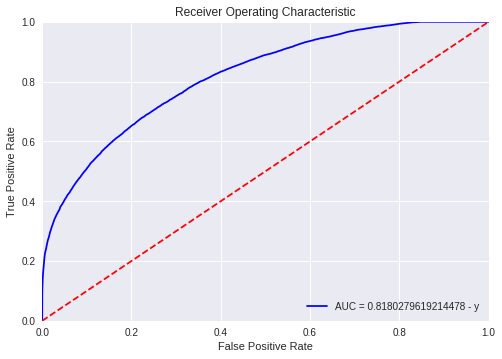

In [ ]:
fit_selected_columns(X, y, ["productListPosition", "population", "brand_code", "marketingChannel_code",
                            "device_code", "productListPosition_normalized", "price", "discountPercent",
                            "scorePopularity_code", "scorePopularityGPTestC", "voivodeship_code"])

# Notes

In [ ]:
plot_feature(model=xgb, x_source=dfXy[cols_to_fit].iloc[60], feature_number=1, feature_range=range(0,2000,10))
#plot_feature(model=xgb, x_source=dfXy[cols_to_fit], feature_number=1, feature_range, feature_categories=list(dfXy['productListPosition'].cat.categories))

Rejected columns:   
* statusScore